In [1]:
import cv2 #opencv
import numpy as np #ベクトル計算
import matplotlib.pyplot as plt #グラフ
import pandas as pd #データフレーム

ここから論文に記載した内容を関数にしたもの
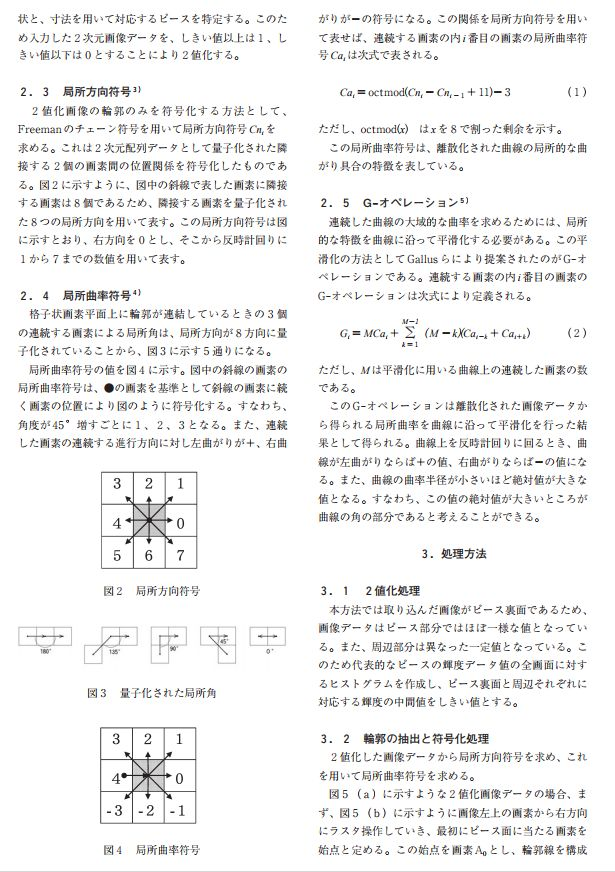

In [2]:
#%%輪郭画像から隣接画素間の角度を計算
def contour2deg(contour):
    #最初と最後の画素のつなぎを計算するため、一旦最後の画素を頭につなげる
    contour = np.vstack([contour[-1,:],contour])
    #画素間の差分を計算
    diff = np.diff(contour,axis=0)    
    #画素間の角度計算
    atan = np.rad2deg(np.arctan2(diff[:,1],diff[:,0]))
    # -180°～180° → 0°～360°
    atan[atan<0] = atan[atan<0] + 360
    return np.int16(atan)

In [3]:
#%%Freeman chan code による、局所方向符号
def deg2cn(deg):
    cn = deg//45
    return cn

In [4]:
#%%局所曲率符号

#8の剰余の計算
def octmod(x):
    y = x%8
    return y

#局所曲率符号の計算
def cn2ca(cn):
    #最初と最後の画像のつなぎを計算するため、一旦最後の画素を頭につなげる
    cn = np.r_[cn[-1],cn]
    #cnの計算
    tmp=[]
    for idx,i in enumerate(cn): #enumerateは、インデックスと要素を同時に取り出せる
        if idx>0:#1つ目(最初と最後の画素のつなぎ目)を飛ばす
            tmp.append(octmod(cn[idx] -cn[idx-1] +11)-3) #論文記載の式
    tmp = np.array(tmp)
    return tmp

In [5]:
#%%Ｇオペレーション
def g_operation(ca,M): #何個平均化するか(M)を引数
    G=[]
    
    #M個の画素の平均を計算する際に、最初と最後の画像のつなぎが問題になる。
    #一旦前後に十分多い数add個だけ、要素をつなげておき、上記問題を回避する。
    add = 100 #平均化個数Mに対して、十分多い数を設定する。
    ca2 = np.r_[ca[-add:],ca,ca[:add]]
    
    for idx,i in enumerate(ca):
        idx = idx + add
        gsum = 0        
        #以下論文のG-operationの式
        for k in range(M-1):
            ca_minus = ca2[idx - k]
            ca_plus  = ca2[idx + k]
            gsum = gsum + (M-k)*(ca_minus + ca_plus)
        G.append(M*ca2[idx] + gsum)
    return np.array(G)

####

ここから実行部分

####

In [15]:
#%%画像を読んで2値化
img1  = cv2.imread("01.bmp")
img2 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
ret,img3 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY) 

In [16]:
type(img3)

numpy.ndarray

findcontoursにより輪郭抽出する

In [17]:
#%%輪郭画素抽出
_, contours, hierarchy = cv2.findContours(img3, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
contour = contours[0][:,0,:]

In [18]:
contour

array([[149,  55],
       [148,  56],
       [145,  56],
       [144,  57],
       [143,  57],
       [142,  58],
       [141,  57],
       [140,  58],
       [140,  59],
       [139,  60],
       [138,  60],
       [138,  61],
       [137,  62],
       [137,  67],
       [138,  68],
       [138,  71],
       [137,  72],
       [139,  74],
       [139,  75],
       [138,  76],
       [139,  76],
       [140,  77],
       [140,  78],
       [141,  78],
       [142,  79],
       [142,  80],
       [141,  81],
       [142,  81],
       [143,  82],
       [143,  85],
       [142,  86],
       [142,  89],
       [141,  90],
       [141,  91],
       [140,  92],
       [139,  92],
       [139,  94],
       [138,  95],
       [137,  94],
       [136,  95],
       [135,  95],
       [133,  97],
       [132,  96],
       [130,  96],
       [129,  97],
       [128,  96],
       [127,  97],
       [126,  97],
       [125,  98],
       [124,  98],
       [123,  97],
       [119,  97],
       [118,

In [19]:
#%%局所方向符号
deg = contour2deg(contour)

In [20]:
deg

array([180, 135, 180, 135, 180, 135, 225, 135,  90, 135, 180,  90, 135,
        90,  45,  90, 135,  45,  90, 135,   0,  45,  90,   0,  45,  90,
       135,   0,  45,  90, 135,  90, 135,  90, 135, 180,  90, 135, 225,
       135, 180, 135, 225, 180, 135, 225, 135, 180, 135, 180, 225, 180,
       225, 180, 225, 180, 225, 180, 225, 270, 180, 225, 270, 225, 270,
       225, 315,   0, 270, 315, 270, 315, 180, 225, 270, 315,   0, 270,
       315, 270, 315, 270, 180, 225, 270, 180, 225, 270, 225, 180, 225,
       180, 135, 225, 180, 135, 180, 135, 180, 135, 180, 135, 180, 135,
       225, 135, 180, 135, 225, 135, 180, 135, 180, 135, 180, 135,  90,
       135,  90,   0,  45,  90,  45,  90,  45,  90, 135,  90,   0,  45,
        90, 135,  90,  45, 135,   0,  45,  90, 135,  90, 135, 180, 135,
        90, 135,  90, 135, 225, 135, 180, 135, 225,  90, 135, 180, 225,
       180, 225, 180, 225, 180, 225, 135, 180, 135, 225, 180,  90, 135,
       180,  90, 135,  90, 135,  90, 135,  90, 135,  90,   0,  4

In [13]:
cn = deg2cn(deg)

In [14]:
cn

array([4, 3, 4, 3, 4, 3, 5, 3, 2, 3, 4, 2, 3, 2, 1, 2, 3, 1, 2, 3, 0, 1, 2,
       0, 1, 2, 3, 0, 1, 2, 3, 2, 3, 2, 3, 4, 2, 3, 5, 3, 4, 3, 5, 4, 3, 5,
       3, 4, 3, 4, 5, 4, 5, 4, 5, 4, 5, 4, 5, 6, 4, 5, 6, 5, 6, 5, 7, 0, 6,
       7, 6, 7, 4, 5, 6, 7, 0, 6, 7, 6, 7, 6, 4, 5, 6, 4, 5, 6, 5, 4, 5, 4,
       3, 5, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 5, 3, 4, 3, 5, 3, 4, 3, 4, 3, 4,
       3, 2, 3, 2, 0, 1, 2, 1, 2, 1, 2, 3, 2, 0, 1, 2, 3, 2, 1, 3, 0, 1, 2,
       3, 2, 3, 4, 3, 2, 3, 2, 3, 5, 3, 4, 3, 5, 2, 3, 4, 5, 4, 5, 4, 5, 4,
       5, 3, 4, 3, 5, 4, 2, 3, 4, 2, 3, 2, 3, 2, 3, 2, 3, 2, 0, 1, 2, 3, 2,
       0, 1, 3, 2, 0, 1, 2, 3, 0, 1, 2, 0, 1, 0, 1, 2, 1, 0, 1, 0, 7, 0, 1,
       7, 0, 7, 1, 0, 6, 7, 1, 6, 7, 0, 7, 1, 0, 1, 0, 1, 2, 1, 2, 0, 1, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 1, 0, 7, 1, 0, 1, 0, 7, 0, 1,
       7, 0, 1, 0, 7, 0, 1, 0, 7, 0, 1, 0, 7, 1, 0, 7, 0, 1, 0, 7, 0, 1, 0,
       7, 1, 0, 7, 1, 0, 7, 0, 1, 0, 7, 0, 1, 0, 7, 1, 0, 7, 0, 1, 0, 7, 1,
       0, 7,

In [21]:
#%%局所曲率符号
ca = cn2ca(cn)

In [22]:
ca

array([-1, -1,  1, -1,  1, -1,  2, -2, -1,  1,  1, -2,  1, -1, -1,  1,  1,
       -2,  1,  1, -3,  1,  1, -2,  1,  1,  1, -3,  1,  1,  1, -1,  1, -1,
        1,  1, -2,  1,  2, -2,  1, -1,  2, -1, -1,  2, -2,  1, -1,  1,  1,
       -1,  1, -1,  1, -1,  1, -1,  1,  1, -2,  1,  1, -1,  1, -1,  2,  1,
       -2,  1, -1,  1, -3,  1,  1,  1,  1, -2,  1, -1,  1, -1, -2,  1,  1,
       -2,  1,  1, -1, -1,  1, -1, -1,  2, -1, -1,  1, -1,  1, -1,  1, -1,
        1, -1,  2, -2,  1, -1,  2, -2,  1, -1,  1, -1,  1, -1, -1,  1, -1,
       -2,  1,  1, -1,  1, -1,  1,  1, -1, -2,  1,  1,  1, -1, -1,  2, -3,
        1,  1,  1, -1,  1,  1, -1, -1,  1, -1,  1,  2, -2,  1, -1,  2, -3,
        1,  1,  1, -1,  1, -1,  1, -1,  1, -2,  1, -1,  2, -1, -2,  1,  1,
       -2,  1, -1,  1, -1,  1, -1,  1, -1, -2,  1,  1,  1, -1, -2,  1,  2,
       -1, -2,  1,  1,  1, -3,  1,  1, -2,  1, -1,  1,  1, -1, -1,  1, -1,
       -1,  1,  1, -2,  1, -1,  2, -1, -2,  1,  2, -3,  1,  1, -1,  2, -1,
        1, -1,  1,  1, -1

In [23]:
#%%Gオペレーション
g = g_operation(ca,M=10)
g_abs = np.abs(g) #Gは絶対値だと思うので絶対値に直す。

In [24]:
g_abs

array([30, 31, 14, 31, 13, 31, 29, 53, 34,  7,  9, 53,  5, 37, 33,  4,  9,
       50, 13,  8, 70, 14, 20, 40, 24, 24, 29, 52, 29, 37, 39,  6, 39,  6,
       37, 35, 25, 37, 52, 32, 28, 14, 50, 16, 16, 47, 36, 22, 13, 26, 29,
       13, 27, 12, 28, 11, 30, 11, 32, 34, 28, 35, 36,  5, 32, 11, 52, 29,
       34, 26, 17, 20, 59, 22, 21, 18, 17, 47, 12, 27, 10, 31, 54,  5,  2,
       57,  8,  5, 34, 37,  8, 32, 32, 28, 29, 32, 13, 27, 18, 25, 22, 20,
       20, 20, 44, 42, 22, 22, 38, 46, 14, 34,  7, 37,  4, 39, 40,  0, 35,
       56,  7,  9, 27, 17, 21, 21, 23, 22, 40, 22, 24, 24, 18, 14, 46, 58,
       30, 33, 32,  7, 31, 34,  9,  9, 32, 11, 30, 51, 32, 29, 14, 51, 52,
       31, 30, 28, 19, 27, 18, 19, 26, 19, 50, 10, 34, 30, 36, 54,  6, 10,
       54,  7, 35,  9, 32, 11, 31,  8, 31, 48, 11, 15, 15, 23, 49, 17, 39,
       25, 43, 15, 15, 15, 67, 16, 15, 51, 11, 26, 15, 10, 32, 30, 12, 31,
       31, 10, 15, 53,  9, 27, 35, 25, 44, 23, 42, 59, 31, 31,  5, 52,  6,
       41,  3, 38, 41,  2

In [25]:
#%%計算したデータをdataframe形式のテーブルまとめる(pandasを使用)
g_table = np.c_[deg,cn,ca,contour,g_abs]
g_table = pd.DataFrame(g_table,columns=["deg","cn","ca","X","Y","G"])

g_tableに、論文のフォーマットでまとめる
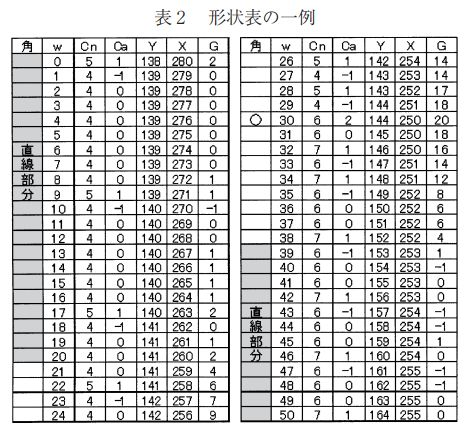

In [26]:
g_table

,deg,cn,ca,X,Y,G
0,180,4,-1,149,55,30
1,135,3,-1,148,56,31
2,180,4,1,145,56,14
3,135,3,-1,144,57,31
4,180,4,1,143,57,13
5,135,3,-1,142,58,31
6,225,5,2,141,57,29
7,135,3,-2,140,58,53
8,90,2,-1,140,59,34
9,135,3,1,139,60,7


In [27]:
#%%Gが大きいもの4点をピックアップする。
#やり方はいろいろあるが、一旦Gでソートしてから4個抽出
g_table2 = g_table.sort_values(by=["G"],ascending=False)
g_table2 = g_table2[:4]

In [28]:
g_table2

,deg,cn,ca,X,Y,G
321,270,6,-3,188,184,84
20,0,0,-3,139,76,70
192,0,0,-3,26,142,67
421,180,4,-3,184,99,64


In [30]:
#%%描画2(Gオペレーション結果：matplotlibで描画)
fig2 = plt.figure(2)
ax = fig2.add_subplot()
plt.scatter(g_table["X"],g_table["Y"],c=g_table["G"],cmap="gray",alpha=1)
plt.scatter(g_table2["X"],g_table2["Y"],marker="+",c="red",s=200)

plt.grid(True) #グラフへのグリッド追加
plt.title("G") #グラフへのタイトル追加
plt.tight_layout() #グラフのレイアウト調整

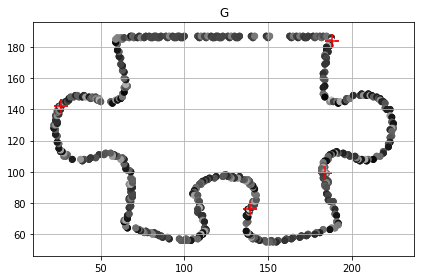

In [31]:
plt.show()